# Makespan minimization with LP (COIN-OR)

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

# DataFrame analyses
from src.DataFrameAnalyses import DataFramePlotGenerator, DataFrameChecker

# Domain data
from src.domain.Query import RoutingQuery
from src.domain.Initializer import JobsInitializer
from src.domain.Collection import LiveJobCollection

# Solver
from src.solvers.LP_Solver import Solver

# Data store access
from config.project_config import get_data_path

pd.set_option('display.min_rows', 16)
pd.set_option('display.max_rows', 29)

In [2]:
# File paths
examples_path = get_data_path("examples")
logs_path = get_data_path("logs")

# Solver limits
max_solver_time = 60*2 # 2 minutes

### I. Load routing

In [3]:
routings = RoutingQuery.get_by_source_name(source_name="Fisher and Thompson 10x10")

# Example
for routing in routings:
    print(routing)
    for operation in routing.operations[:2]:
        print(f" {operation}")

Routing(id='01-00', source_id=1)
 RoutingOperation(routing_id='01-00', position_number=0, machine_id=4, duration=29)
 RoutingOperation(routing_id='01-00', position_number=1, machine_id=1, duration=78)
Routing(id='01-01', source_id=1)
 RoutingOperation(routing_id='01-01', position_number=0, machine_id=4, duration=43)
 RoutingOperation(routing_id='01-01', position_number=1, machine_id=10, duration=90)
Routing(id='01-02', source_id=1)
 RoutingOperation(routing_id='01-02', position_number=0, machine_id=1, duration=91)
 RoutingOperation(routing_id='01-02', position_number=1, machine_id=4, duration=85)
Routing(id='01-03', source_id=1)
 RoutingOperation(routing_id='01-03', position_number=0, machine_id=1, duration=81)
 RoutingOperation(routing_id='01-03', position_number=1, machine_id=10, duration=95)
Routing(id='01-04', source_id=1)
 RoutingOperation(routing_id='01-04', position_number=0, machine_id=10, duration=14)
 RoutingOperation(routing_id='01-04', position_number=1, machine_id=4, durat

### II. Create jobs routings (without any change)

In [4]:

jobs = JobsInitializer.create_simple_jobs(routings = routings, shuffle=False)
for job in jobs:
    print(job)

Job(id='01-0000', routing_id='01-00', arrival=None, earliest_start=0, due_date=None, sum_duration=395, max_bottleneck_utilization=None)
Job(id='01-0001', routing_id='01-01', arrival=None, earliest_start=0, due_date=None, sum_duration=510, max_bottleneck_utilization=None)
Job(id='01-0002', routing_id='01-02', arrival=None, earliest_start=0, due_date=None, sum_duration=568, max_bottleneck_utilization=None)
Job(id='01-0003', routing_id='01-03', arrival=None, earliest_start=0, due_date=None, sum_duration=655, max_bottleneck_utilization=None)
Job(id='01-0004', routing_id='01-04', arrival=None, earliest_start=0, due_date=None, sum_duration=393, max_bottleneck_utilization=None)
Job(id='01-0005', routing_id='01-05', arrival=None, earliest_start=0, due_date=None, sum_duration=496, max_bottleneck_utilization=None)
Job(id='01-0006', routing_id='01-06', arrival=None, earliest_start=0, due_date=None, sum_duration=416, max_bottleneck_utilization=None)
Job(id='01-0007', routing_id='01-07', arrival=No

In [5]:
# Create collection
jobs_collection = LiveJobCollection(jobs)
print(f"Total number of operations: {jobs_collection.count_operations()}")

Total number of operations: 100


## Scheduling

### A) HiGHS with PuLP
> high performance serial and parallel solver

In [6]:
solver = Solver(
    jobs_collection = jobs_collection,
    var_cat="Integer"
)
solver.build_makespan_problem()

In [7]:
log_file_path = logs_path / "makespan_highs.log"

solver.solve_problem(
    solver_type= "HiGHS",
    time_limit = max_solver_time,
    relative_gap_limit= 0.05,
    log_file= log_file_path
)

solver.print_solver_info()

Status               : Optimal
Objective value      : 982.0
Number of variables  : 1001
Number of constraints: 1900
Runtime              : 121.29


In [8]:
schedule_job_collection = solver.get_schedule()
df_schedule = schedule_job_collection.to_operations_dataframe()
df_schedule.head(12)

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-0000,01-00,0,M00,115.0,29,144.0,None,0,None
1,01-0000,01-00,1,M01,463.0,78,541.0,None,0,None
2,01-0000,01-00,2,M02,550.0,9,559.0,None,0,None
3,01-0000,01-00,3,M03,576.0,36,612.0,None,0,None
4,01-0000,01-00,4,M04,636.0,49,685.0,None,0,None
5,01-0000,01-00,5,M05,685.0,11,696.0,None,0,None
6,01-0000,01-00,6,M06,696.0,62,758.0,None,0,None
7,01-0000,01-00,7,M07,768.0,56,824.0,None,0,None
8,01-0000,01-00,8,M08,832.0,44,876.0,None,0,None
9,01-0000,01-00,9,M09,961.0,21,982.0,None,0,None


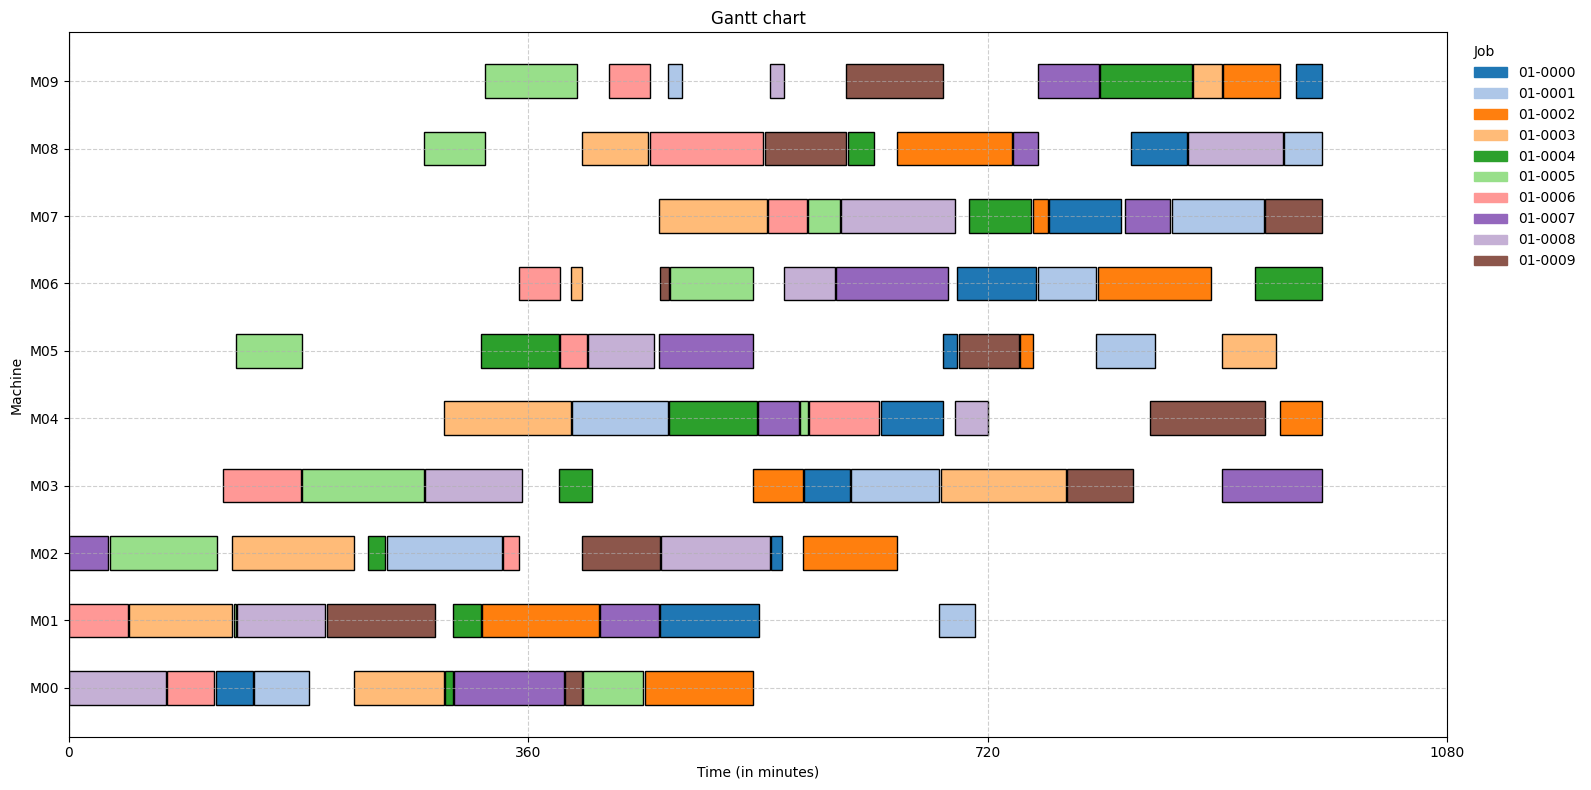

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [9]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)

### B) CBC - COIN-OR Branch and Cut

In [10]:
solver = Solver(
    jobs_collection = jobs_collection,
    var_cat="Integer"
)
solver.build_makespan_problem()

In [11]:
log_file_path = logs_path / "makespan_cbc.log"

solver.solve_problem(
    solver_type= "CBC",
    time_limit = max_solver_time,
    relative_gap_limit= 0.05,
    log_file= log_file_path
)
solver.print_solver_info()

Status               : Optimal
Objective value      : 1165.0
Number of variables  : 1001
Number of constraints: 1900
Runtime              : 120.28


In [12]:
schedule_job_collection = solver.get_schedule()
df_schedule = schedule_job_collection.to_operations_dataframe()
df_schedule.head(12)

,Job,Routing_ID,Operation,Machine,Start,Processing Time,End,Arrival,Ready Time,Due Date
0,01-0000,01-00,0,M00,84.0,29,113.0,None,0,None
1,01-0000,01-00,1,M01,451.0,78,529.0,None,0,None
2,01-0000,01-00,2,M02,529.0,9,538.0,None,0,None
3,01-0000,01-00,3,M03,813.0,36,849.0,None,0,None
4,01-0000,01-00,4,M04,849.0,49,898.0,None,0,None
5,01-0000,01-00,5,M05,933.0,11,944.0,None,0,None
6,01-0000,01-00,6,M06,980.0,62,1042.0,None,0,None
7,01-0000,01-00,7,M07,1044.0,56,1100.0,None,0,None
8,01-0000,01-00,8,M08,1100.0,44,1144.0,None,0,None
9,01-0000,01-00,9,M09,1144.0,21,1165.0,None,0,None


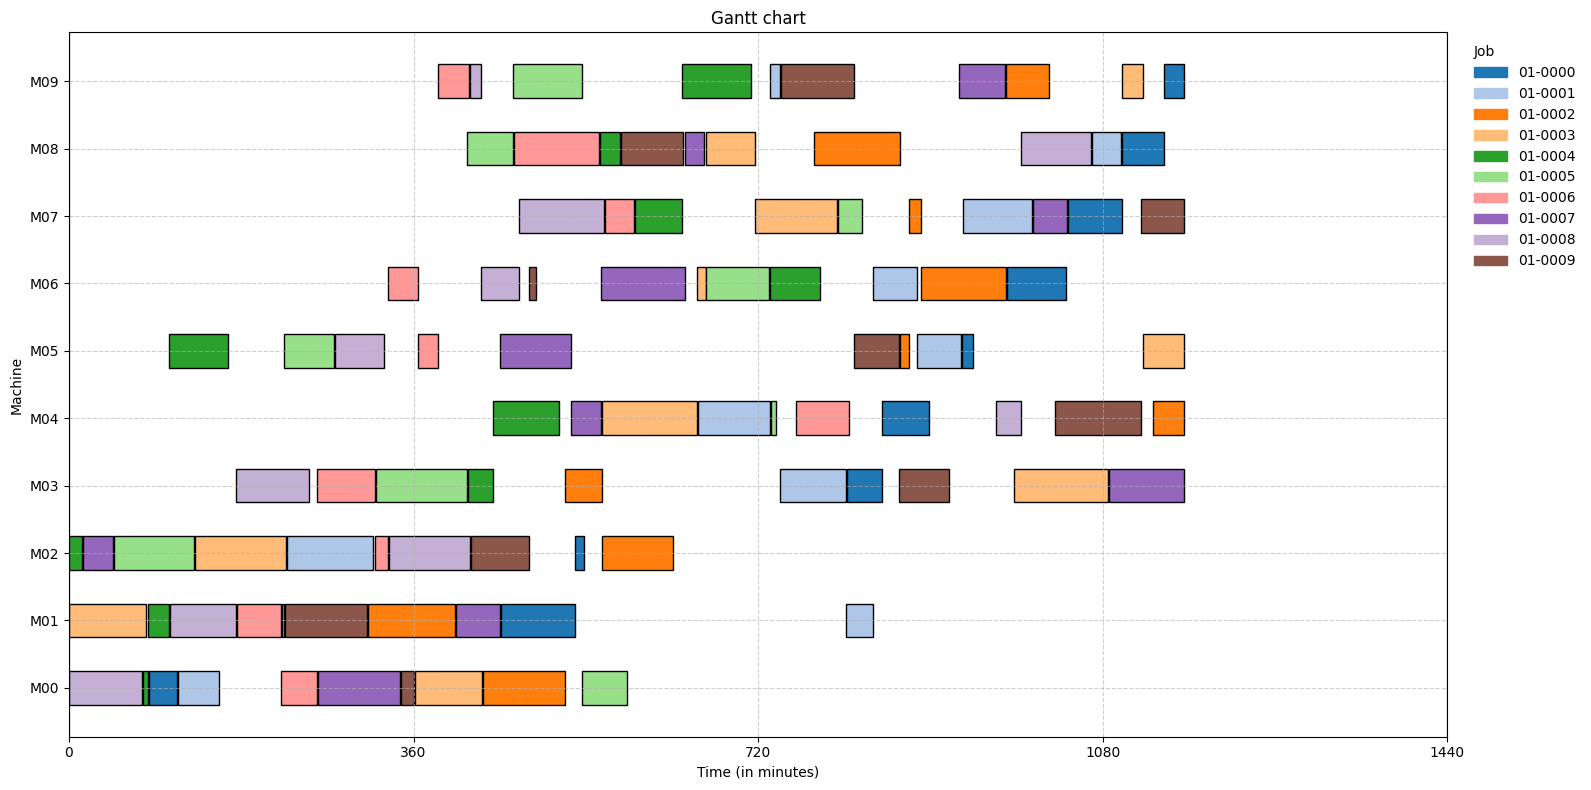

+ No machine conflicts found.
+ All job operations are scheduled in non-overlapping, correct sequence.
+ All operations start at or after the earliest allowed time.
+ All durations match the difference between start and end.


True

In [13]:
DataFramePlotGenerator.get_gantt_chart_figure(df_schedule, perspective="Machine")
plt.show()
DataFrameChecker.check_core_schedule_constraints(df_schedule)
DataFrameChecker.is_duration_correct(df_schedule)